<a href="https://colab.research.google.com/github/lc0/practical-ml-dahoam/blob/safari/S_01_TF_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structuring data into `tf.data.Dataset`

## Optional: Mount Google Drive with dataset

Mount and copy dataset to Google Drive

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [11]:
!ls -laF /gdrive/'My Drive'/talks/2019-practical-ml

total 63
drwx------ 2 root root  4096 May 21 19:20 dataset/
drwx------ 2 root root  4096 May 27 15:01 models/
-rw------- 1 root root 56194 May 27 15:03 shoe.png


In [0]:
cp -R /gdrive/'My Drive'/talks/2019-practical-ml/dataset/google_dataset google_dataset

In [21]:
ls -laF google_dataset/google_dataset

total 44
drwx------ 7 root root  4096 Oct 23 10:14  ./
drwx------ 8 root root  4096 Oct 23 10:14  ../
drwx------ 2 root root  4096 Oct 23 10:14 'converse chuck 70'/
-rw------- 1 root root 12292 Oct 23 10:14  .DS_Store
drwx------ 2 root root  4096 Oct 23 10:14 'Exaggerated Soles'/
drwx------ 2 root root  4096 Oct 23 10:14 'nike air max 90 essentials'/
drwx------ 2 root root  4096 Oct 23 10:14 'nike react'/
drwx------ 2 root root  4096 Oct 23 10:14 'Tie Dye sneakers'/


Why `tf.data.Dataset`?

The `tf.data` API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. The `tf.data` API makes it easy to deal with large amounts of data, different data formats, and complicated transformations.



Keras and Tensorflow accept Datasets in all of their training and evaluation functions. Once you load data in a Dataset, the API offers all the common functionalities that are useful for neural network training data:



## TF2 setup

TensorFlow 2.0 was just recently released so would make sense to run all of our experiments in TF2

In [4]:
%tensorflow_version 2.x

import tensorflow as tf

print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


In [0]:
import math

from matplotlib import pyplot as plt
import numpy as np

### Reading dataset

In [0]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Read images and labels 
1. Use `fileset=`[`tf.data.Dataset.list_files`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) to scan the data folder
1. Iterate through the dataset of filenames: `for filename in fileset:...` . 
 * Does it work ?
 * No! But Python iteration though a Dataset works in eager mode. Enable eager mode in the first cell, restart the runtime and try again.
 * tip: to limit the size of the dataset for display, you can use [`Dataset.take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Like this: `for data in dataset.take(10): ....`
 * It works but why are Tensors returned ? Get proper values by applying .numpy() to the tensors.
1. Use [`tf.data.Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to decode the JPEG files. You will find useful TF code snippets below.
 * Iterate on the image dataset. You can use .numpy().shape to only see the data sizes.
  * Are all images of the same size ?
1. Now create a training dataset: you have images but you also need labels:
 *  the labels (flower names) are the directory names. You will find useful TF code snippets below for parsing them.
 * If you do "`return image, label`" in the decoding function, you will have a Dataset of pairs (image, label).
1. Look at the flowers with the `display_9_images_from_dataset` function. It expects the Dataset to have `(image, label)` elements.
1. Code for iterating on a dataset in non-eager mode is also provided in the snippets below. Have a look, it is a bit more complex...

In [0]:
GCS_PATTERN = 'google_dataset/*/*.jpg'

CLASSES = [b'converse chuck 70', b'Exaggerated Soles', b'nike air max 90 essentials', b'nike react', b'Tie Dye sneakers']

In [23]:
!ls -laF

total 20
drwxr-xr-x 1 root root 4096 Oct 23 10:15 ./
drwxr-xr-x 1 root root 4096 Oct 23 10:07 ../
drwxr-xr-x 1 root root 4096 Oct 21 15:29 .config/
drwx------ 8 root root 4096 Oct 23 10:14 google_dataset/
drwxr-xr-x 1 root root 4096 Oct 21 15:29 sample_data/


Pattern matches 210 images.
google_dataset/Exaggerated Soles/17.1253217_1_large.jpg
google_dataset/converse chuck 70/37.converse-chuck-70-floral-leather-low-top-1a55-600.jpg
google_dataset/Tie Dye sneakers/34.9f4bc188dd3bae60d2265fc7d7e1ae48.jpg
google_dataset/nike react/14.Nike-React-Element-87-Parra-White-Multi-Shoes-On-Sale.jpg
google_dataset/Exaggerated Soles/8.Both%20men%20Gao%20Runner%20Exaggerated%20soles%20242825%20HVLVAUD.jpg
google_dataset/converse chuck 70/48.09-04-2018_converse_chucktaylor1970sox_gymred_navy_160493c_gh_2.jpg
google_dataset/nike air max 90 essentials/6.https%3A%2F%2Fhypebeast.com%2Fimage%2F2018%2F12%2Fnike-air-max-90-essential-armory-blue-release-0.jpg
google_dataset/Tie Dye sneakers/50.41eWdlgJtdL._UL1500_.jpg
google_dataset/converse chuck 70/4.162050C_D_08X1.jpg
google_dataset/nike react/23.61Swwuf%2BrHL._UX395_.jpg
(600, 1052, 3)
(1300, 1300, 3)
(800, 1000, 3)
(324, 400, 3)
(281, 395, 3)
(1000, 1000, 3)
(395, 395, 3)
(271, 600, 3)
(323, 600, 3)
(749, 1200

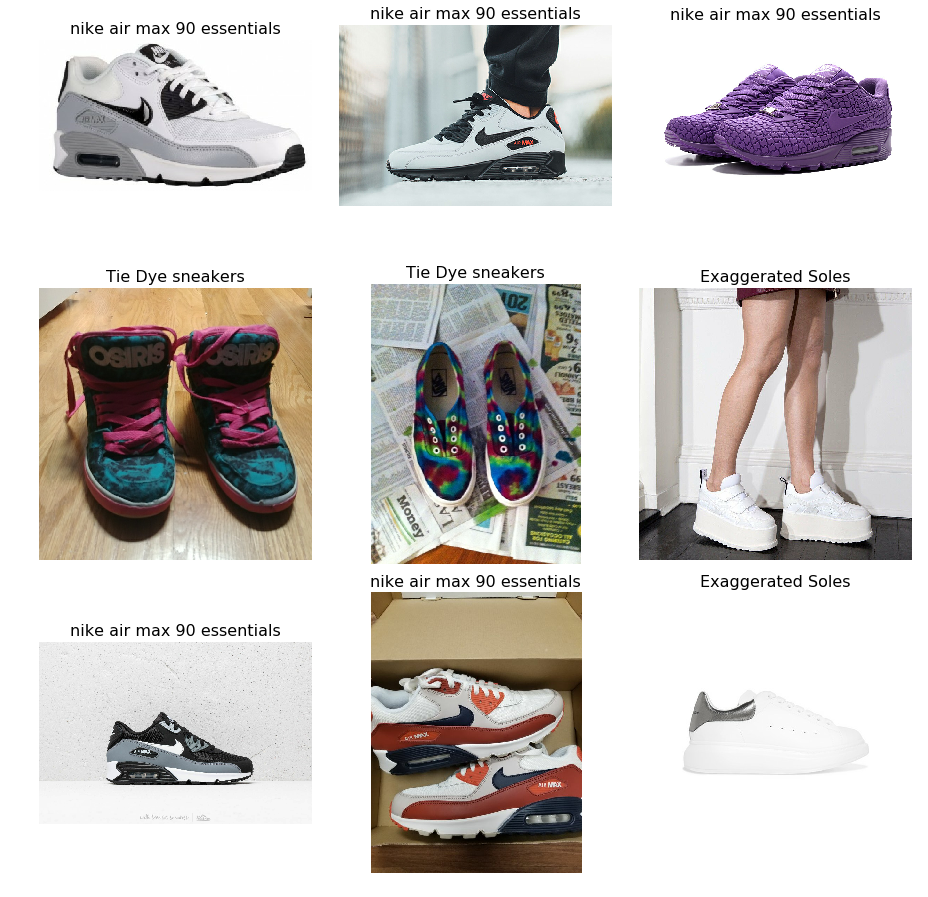

In [24]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
print("Pattern matches {} images.".format(nb_images))

# List files for a dataset 
filenames_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
for filename in filenames_dataset.take(10):
  print(filename.numpy().decode('utf-8'))

def decode_jpeg(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  return image

image_dataset = filenames_dataset.map(decode_jpeg)
for image in image_dataset.take(10):
  print(image.numpy().shape)

def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

dataset = filenames_dataset.map(decode_jpeg_and_label)
for image, label in dataset.take(10):
  print(image.numpy().shape, label.numpy().decode('utf-8'))

display_9_images_from_dataset(dataset)

## TFRecord

The Tensor Processing Unit (TPU) hardware accelerators we will be using in this lab are very fast. The challenge is often to feed them data fast enough to keep them busy. Google Cloud Storage (GCS) is capable of sustaining very high throughput but as with all cloud storage systems, initiating a connection costs some network back and forth. Therefore, having our data stored as thousands of individual files is not ideal. We are going to batch them in a smaller number of files and use the power of tf.data.Dataset to read from multiple files in parallel.

The code that loads image files, resizes them to a common size and then stores them across 16 TFRecord files is in the following notebook. Please quickly read through it. Executing it is not necessary since properly TFRecord-formatted data will be provided for the rest of the codelab.

In [0]:
TARGET_SIZE = [192, 192]
# SHARDS = 16

SHARDS = 1


In [0]:
def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  
dataset2 = dataset.map(resize_and_crop_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)  

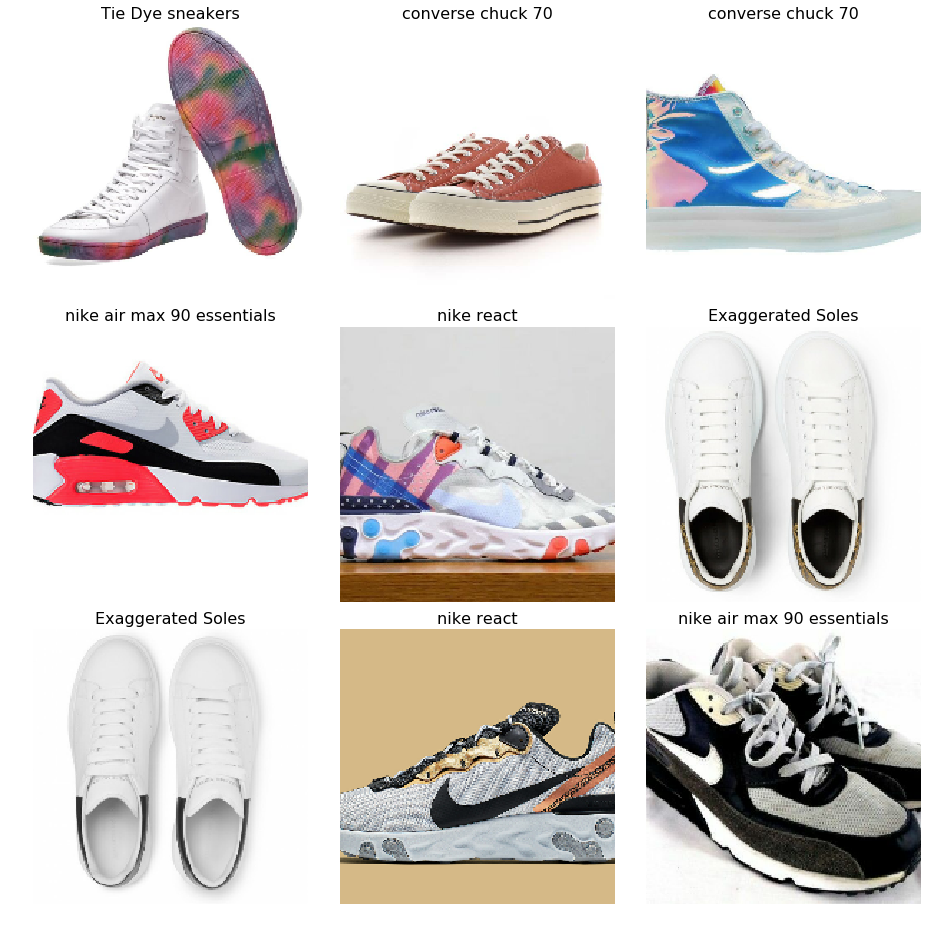

In [27]:
display_9_images_from_dataset(dataset2)

#### Speed test: too slow
Google Cloud Storage is capable of great throughput but has a per-file access penalty. Run the cell below and see that throughput is around 8 images per second. That is too slow. Training on thousands of individual files will not work. We have to use the **TFRecord** format to group files together. 

In [28]:
%%time

display_dataset = dataset2.batch(8)
for image, label in display_dataset.take(30):
  print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['nike air max 90 essentials', 'converse chuck 70', 'nike air max 90 essentials', 'converse chuck 70', 'converse chuck 70', 'converse chuck 70', 'nike react', 'Tie Dye sneakers'])
Image batch shape (8, 192, 192, 3), ['nike react', 'nike react', 'nike air max 90 essentials', 'Exaggerated Soles', 'converse chuck 70', 'converse chuck 70', 'nike air max 90 essentials', 'nike react'])
Image batch shape (8, 192, 192, 3), ['converse chuck 70', 'converse chuck 70', 'Exaggerated Soles', 'nike air max 90 essentials', 'Exaggerated Soles', 'Tie Dye sneakers', 'nike react', 'Tie Dye sneakers'])
Image batch shape (8, 192, 192, 3), ['nike air max 90 essentials', 'Tie Dye sneakers', 'nike air max 90 essentials', 'converse chuck 70', 'nike air max 90 essentials', 'converse chuck 70', 'nike react', 'nike air max 90 essentials'])
Image batch shape (8, 192, 192, 3), ['Exaggerated Soles', 'Tie Dye sneakers', 'nike react', 'converse chuck 70', 'Exaggerated Soles', 'nike r

## Recompress the images
The bandwidth savings outweight the decoding CPU cost

In [29]:
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print(f"Shard size is {shard_size}, there will be one 'batch' of images per file")

def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

Shard size is 210, there will be one 'batch' of images per file


In [0]:
GCS_OUTPUT = './'

In [31]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
      "one_hot_class": _float_feature(one_hot_class.tolist()) # variable length  list of floats, n=len(CLASSES)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ./00-210.tfrec containing 210 records


### Read  from TFRecord Dataset
**Resume running the cells**

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
# to read from multiple TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

dataset4 = tf.data.Dataset.list_files(GCS_OUTPUT + "*.tfrec")
dataset4 = dataset4.with_options(option_no_order)
#dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
dataset4 = dataset4.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset4 = dataset4.shuffle(300)

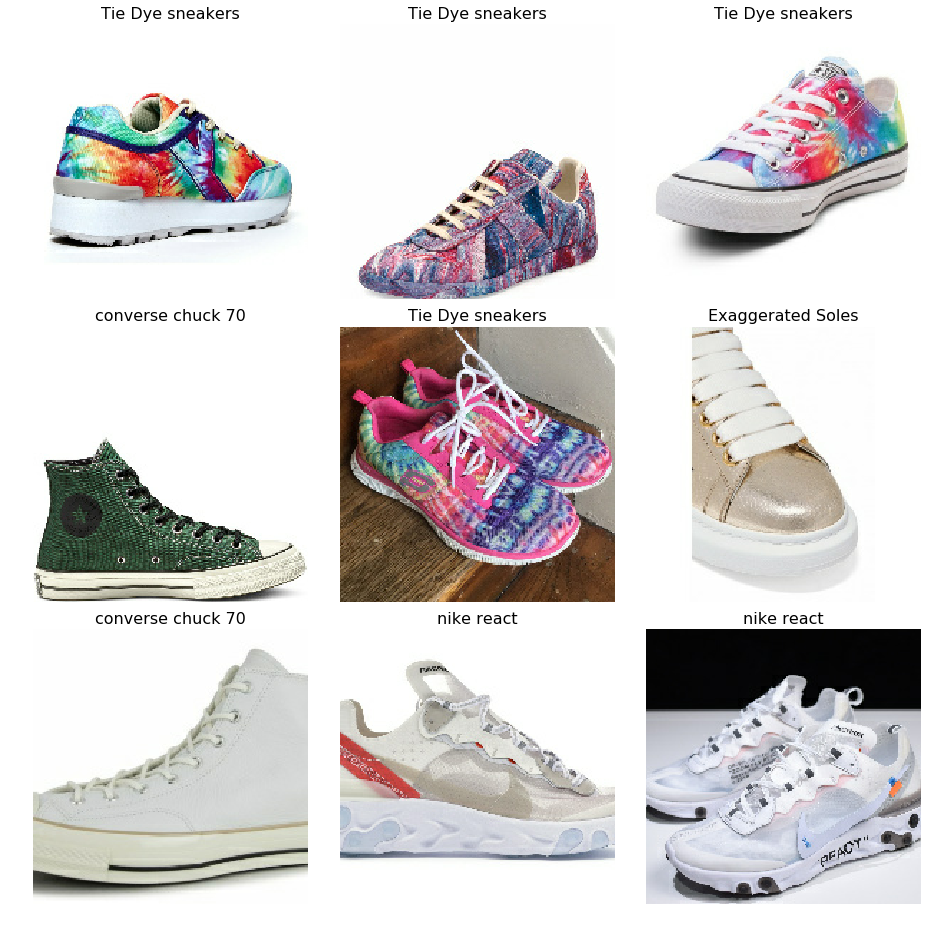

In [33]:
display_dataset = dataset4.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))
display_9_images_from_dataset(display_dataset)

#### Speed test: fast
Loading training data is not a bottleneck anymore

In [34]:
%time

for image, class_num, label, height, width, one_hot_class in dataset4.take(300):
    print("Image shape {}, {}x{} px, class={} ({:>10}, {})".format(image.numpy().shape, width, height, class_num, label.numpy().decode('utf8'), one_hot_class))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs
Image shape (192, 192, 3), 192x192 px, class=0 (converse chuck 70, [1. 0. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=1 (Exaggerated Soles, [0. 1. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=2 (nike air max 90 essentials, [0. 0. 1. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=4 (Tie Dye sneakers, [0. 0. 0. 0. 1.])
Image shape (192, 192, 3), 192x192 px, class=4 (Tie Dye sneakers, [0. 0. 0. 0. 1.])
Image shape (192, 192, 3), 192x192 px, class=2 (nike air max 90 essentials, [0. 0. 1. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=4 (Tie Dye sneakers, [0. 0. 0. 0. 1.])
Image shape (192, 192, 3), 192x192 px, class=1 (Exaggerated Soles, [0. 1. 0. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=2 (nike air max 90 essentials, [0. 0. 1. 0. 0.])
Image shape (192, 192, 3), 192x192 px, class=3 (nike react, [0. 0. 0. 1. 0.])
Image shape (192, 192, 3), 192x192 px, class=1 (Exaggerated Soles

### Links:

*   https://www.tensorflow.org/alpha/tutorials/load_data/images
*   https://twitter.com/martin_gorner
*   https://codelabs.developers.google.com/codelabs/keras-flowers-data/#3
*   https://codelabs.developers.google.com/codelabs/keras-flowers-data/#4
*   https://www.tensorflow.org/guide/performance/datasets

